# Decision Tree

In [1]:
from joblib import dump

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, balanced_accuracy_score,  f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("../../../data/combined_subjects.csv")

In [3]:
df.head()

,Unnamed: 0,net_acc_mean,net_acc_std,net_acc_min,net_acc_max,EDA_phasic_mean,EDA_phasic_std,EDA_phasic_min,EDA_phasic_max,EDA_smna_mean,...,ACC_z_min,ACC_z_max,0_mean,0_std,0_min,0_max,BVP_peak_freq,TEMP_slope,subject,label
0,0,1.331891,0.153556,1.014138,1.678399,2.247876,1.112076,0.367977,4.459367,1.592308,...,-0.000026,0.000060,0.027558,0.013523,0.000000,0.087383,0.080556,-0.000102,2,1
1,1,1.218994,0.090108,1.014138,1.485800,1.781323,1.203991,0.232625,4.459367,1.347750,...,-0.000026,0.000060,0.023420,0.015310,0.000000,0.087383,0.144444,-0.000424,2,1
2,2,1.143312,0.110987,0.948835,1.485800,1.173169,1.285422,0.006950,4.459367,0.752335,...,-0.000015,0.000049,0.018759,0.012604,0.000000,0.071558,0.102778,-0.000814,2,1
3,3,1.020669,0.135308,0.811090,1.239944,0.311656,0.278650,0.006950,1.303071,0.198576,...,-0.000005,0.000037,0.022888,0.012180,0.000688,0.054356,0.108333,-0.000524,2,1
4,4,0.887458,0.116048,0.727406,1.125306,0.163826,0.110277,0.006950,0.369298,0.118080,...,0.000002,0.000037,0.028105,0.010415,0.002752,0.054356,0.147222,-0.000165,2,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091 entries, 0 to 2090
Data columns (total 45 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       2091 non-null   int64  
 1   net_acc_mean     2091 non-null   float64
 2   net_acc_std      2091 non-null   float64
 3   net_acc_min      2091 non-null   float64
 4   net_acc_max      2091 non-null   float64
 5   EDA_phasic_mean  2091 non-null   float64
 6   EDA_phasic_std   2091 non-null   float64
 7   EDA_phasic_min   2091 non-null   float64
 8   EDA_phasic_max   2091 non-null   float64
 9   EDA_smna_mean    2091 non-null   float64
 10  EDA_smna_std     2091 non-null   float64
 11  EDA_smna_min     2091 non-null   float64
 12  EDA_smna_max     2091 non-null   float64
 13  EDA_tonic_mean   2091 non-null   float64
 14  EDA_tonic_std    2091 non-null   float64
 15  EDA_tonic_min    2091 non-null   float64
 16  EDA_tonic_max    2091 non-null   float64
 17  BVP_mean      

## Data Preparation

In [5]:
features = ["net_acc_std", "net_acc_max", "EDA_tonic_mean", "EDA_tonic_min", "EDA_tonic_max", "label"]

In [6]:
df_feat = df[features]
df_feat.head()

,net_acc_std,net_acc_max,EDA_tonic_mean,EDA_tonic_min,EDA_tonic_max,label
0,0.153556,1.678399,0.608263,-1.213173,2.554750,1
1,0.090108,1.485800,0.731985,-1.213173,2.477276,1
2,0.110987,1.485800,1.110242,-1.213173,2.037179,1
3,0.135308,1.239944,1.598995,0.959752,2.037179,1
4,0.116048,1.125306,1.342085,0.945946,2.037179,1


In [7]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091 entries, 0 to 2090
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   net_acc_std     2091 non-null   float64
 1   net_acc_max     2091 non-null   float64
 2   EDA_tonic_mean  2091 non-null   float64
 3   EDA_tonic_min   2091 non-null   float64
 4   EDA_tonic_max   2091 non-null   float64
 5   label           2091 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 98.1 KB


### Merged Amusement

In [8]:
df_feat_merged_amusement = df_feat.copy()
df_feat_merged_amusement["label"] = df_feat_merged_amusement["label"].replace([0], 1)

In [9]:
df_feat_merged_amusement["label"].unique()

array([1, 2])

In [10]:
y_merged_amusement = np.array(df_feat_merged_amusement.pop('label'))
X_merged_amusement = np.array(df_feat_merged_amusement)

In [11]:
X_train_merged_amusement, X_test_merged_amusement, y_train_merged_amusement, y_test_merged_amusement = train_test_split(X_merged_amusement, y_merged_amusement, test_size=0.25, random_state=42)

### Dropped Amusement

In [12]:
df_feat_no_amusement = df_feat[df_feat["label"] != 0]

In [13]:
df_feat_no_amusement["label"].unique()

array([1, 2])

In [14]:
y_no_amusement = np.array(df_feat_no_amusement.pop('label'))
X_no_amusement = np.array(df_feat_no_amusement)

In [15]:
X_train_no_amusement, X_test_no_amusement, y_train_no_amusement, y_test_no_amusement = train_test_split(X_no_amusement, y_no_amusement, test_size=0.25, random_state=42)

## Training

In [16]:
parameters = dict(
    criterion=("gini", "entropy", "log_loss"),
    splitter=("best", "random"),
    max_depth=(3, 5, 7, 9, 11),
    random_state=(42,)
)

In [17]:
tree = DecisionTreeClassifier()

### Merged Amusement

In [18]:
clf_tree_merged_amusement = GridSearchCV(estimator=tree, param_grid=parameters)

In [19]:
clf_tree_merged_amusement.fit(X_train_merged_amusement, y_train_merged_amusement)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': (3, 5, 7, 9, 11), 'random_state': (42,),
                         'splitter': ('best', 'random')})

In [20]:
clf_tree_merged_amusement.best_estimator_

DecisionTreeClassifier(max_depth=11, random_state=42)

In [21]:
dump(clf_tree_merged_amusement.best_estimator_, "clf_tree_merged_amusement_top_5_feat.joblib")

['clf_tree_merged_amusement_top_5_feat.joblib']

### Dropped Amusement

In [22]:
clf_tree_no_amusement = GridSearchCV(estimator=tree, param_grid=parameters)

In [23]:
clf_tree_no_amusement.fit(X_train_no_amusement, y_train_no_amusement)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': (3, 5, 7, 9, 11), 'random_state': (42,),
                         'splitter': ('best', 'random')})

In [24]:
clf_tree_no_amusement.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=11, random_state=42)

In [25]:
dump(clf_tree_no_amusement.best_estimator_, "clf_tree_no_amusement_top_5_feat.joblib")

['clf_tree_no_amusement_top_5_feat.joblib']

## Evaluation

### Merged Amusement

In [26]:
y_pred_merged_amusement = clf_tree_merged_amusement.predict(X_test_merged_amusement)

In [27]:
accuracy_score(y_test_merged_amusement, y_pred_merged_amusement)

0.9330783938814532

In [28]:
balanced_accuracy_score(y_test_merged_amusement, y_pred_merged_amusement)

0.9095145525235275

In [29]:
f1_score(y_test_merged_amusement, y_pred_merged_amusement)

0.9540078843626807

In [30]:
precision_score(y_test_merged_amusement, y_pred_merged_amusement)

0.9453125

In [31]:
recall_score(y_test_merged_amusement, y_pred_merged_amusement)

0.9628647214854111

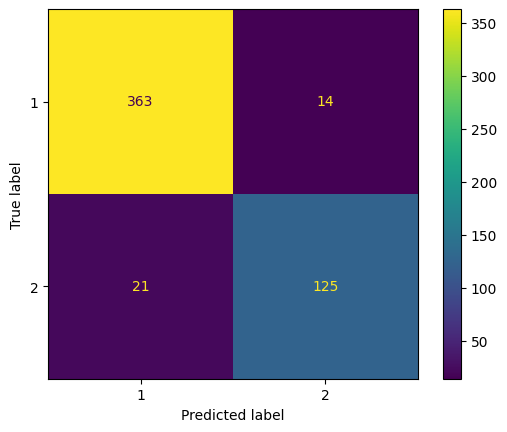

In [32]:
cm = confusion_matrix(y_test_merged_amusement, y_pred_merged_amusement, labels=clf_tree_merged_amusement.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_tree_merged_amusement.best_estimator_.classes_)
disp.plot()
plt.show()

### Dropped Amusement

In [33]:
y_pred_no_amusement = clf_tree_no_amusement.predict(X_test_no_amusement)

In [34]:
accuracy_score(y_test_no_amusement, y_pred_no_amusement)

0.9295454545454546

In [35]:
balanced_accuracy_score(y_test_no_amusement, y_pred_no_amusement)

0.9188034188034189

In [36]:
f1_score(y_test_no_amusement, y_pred_no_amusement)

0.9478991596638656

In [37]:
precision_score(y_test_no_amusement, y_pred_no_amusement)

0.9463087248322147

In [38]:
recall_score(y_test_no_amusement, y_pred_no_amusement)

0.9494949494949495

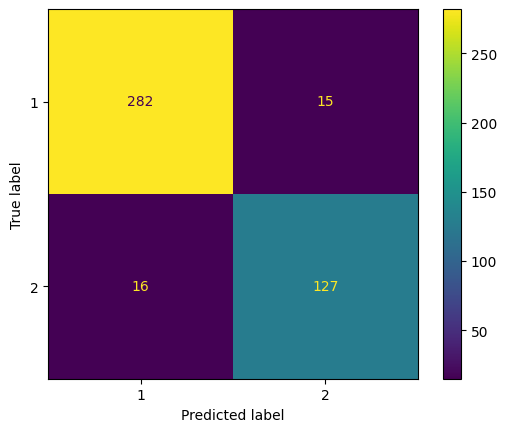

In [39]:
cm = confusion_matrix(y_test_no_amusement, y_pred_no_amusement, labels=clf_tree_no_amusement.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_tree_no_amusement.best_estimator_.classes_)
disp.plot()
plt.show()

## XAI

In [40]:
# def plot_importance(importances, feature_names, title = "Feature Importance"):
#     plt.title(title)
#     plt.barh(range(len(importances)), importances, color='c', align="center")
#     plt.yticks(range(len(importances)), feature_names)
#     plt.xlabel("Relative Importance")
#     plt.show()

In [41]:
# def plot_decision_tree(clf, feature_names, class_names):
#     fig = plt.figure(figsize=(20, 8))
#     vis = plot_tree(clf, feature_names=feature_names, class_names=class_names, max_depth=3, fontsize=7, proportion=True, filled=True, rounded=True)

## Merged Amusement

In [42]:
# plot_importance(
#     importances=clf_tree_merged_amusement.best_estimator_.feature_importances_,
#     feature_names=df_feat_merged_amusement.columns,
# )

In [43]:
# plot_decision_tree(
#     clf=clf_tree_merged_amusement.best_estimator_, 
#     feature_names=df_feat_merged_amusement.columns,
#     class_names=["baseline", "stess"]
# )

### Dropped Amusement

In [44]:
# plot_importance(
#     importances=clf_tree_no_amusement.best_estimator_.feature_importances_,
#     feature_names=df_feat_no_amusement.columns,
# )

In [45]:
# plot_decision_tree(
#     clf=clf_tree_no_amusement.best_estimator_, 
#     feature_names=df_feat_no_amusement.columns,
#     class_names=["baseline", "stess"]
# )